<a href="https://colab.research.google.com/github/elavens/RicePlantDiseasesClassification/blob/main/rpdc6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import resnet50  # Import ResNet-50
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from torch.utils.data import random_split
from tabulate import tabulate

# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Define paths for the dataset
data_dir = '/content/drive/MyDrive/RiceLeafsDisease'
batch_size = 32


In [4]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)


In [5]:
import random
from tabulate import tabulate

# Create dictionaries to store data for train, validation, and test splits for each class
train_class_data = {class_idx: [] for class_idx in range(len(dataset.classes))}
val_class_data = {class_idx: [] for class_idx in range(len(dataset.classes))}
test_class_data = {class_idx: [] for class_idx in range(len(dataset.classes))}


In [6]:
# Define the proportions for train, validation, and test
train_proportion = 0.70
val_proportion = 0.15
test_proportion = 0.15

# Split the data for each class while ensuring balance
for class_idx in range(len(dataset.classes)):
    class_data = [(data, target) for data, target in dataset if target == class_idx]
    random.shuffle(class_data)  # Shuffle the data for each class

    total_samples = len(class_data)
    train_size = int(train_proportion * total_samples)
    val_test_size = int(val_proportion * total_samples)

    train_class_data[class_idx] = class_data[:train_size]
    val_class_data[class_idx] = class_data[train_size:(train_size + val_test_size)]
    test_class_data[class_idx] = class_data[(train_size + val_test_size):(train_size + 2*val_test_size)]

# Merge data for all classes into train, validation, and test sets
train_data = [item for sublist in train_class_data.values() for item in sublist]
val_data = [item for sublist in val_class_data.values() for item in sublist]
test_data = [item for sublist in test_class_data.values() for item in sublist]

# Define data loaders for each set
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
# Print the counts for each class in each set in a tabular form
print("Class-wise Data:")
table_data = []
for class_idx in range(len(dataset.classes)):
    class_name = dataset.classes[class_idx]
    train_count = len(train_class_data[class_idx])
    val_count = len(val_class_data[class_idx])
    test_count = len(test_class_data[class_idx])
    table_data.append([class_name, train_count, val_count, test_count])

# Create headers for the table
headers = ["Class", "Train Sample", "Validation Sample", "Test Sample"]

# Print the tabulated data
print(tabulate(table_data, headers, tablefmt='grid'))

Class-wise Data:
+-----------------------+----------------+---------------------+---------------+
| Class                 |   Train Sample |   Validation Sample |   Test Sample |
+=======================+================+=====================+===============+
| Bacterial Leaf Blight |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Brown Spot            |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Healthy               |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Leaf Blast            |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Leaf Scald            |            306 |                  65 |            65 |
+----------

In [8]:
# Get the total number of classes and total number of images
total_classes = len(dataset.classes)
total_images = len(dataset)

# Get the total number of images in the train, validation, and test sets
total_train_images = len(train_data)
total_val_images = len(val_data)
total_test_images = len(test_data)

print(f"Total Classes: {total_classes}")
print(f"Total Images: {total_images}")

print(f"Total Train Images: {total_train_images}")
print(f"Total Validation Images: {total_val_images}")
print(f"Total Test Images: {total_test_images}")

num_classes = len(dataset.classes)

Total Classes: 6
Total Images: 2628
Total Train Images: 1836
Total Validation Images: 390
Total Test Images: 390


In [9]:
# Load the pre-trained ResNet-50 model and modify it for your classification task
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Modify the fully connected layer for your number of classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []  # List to store testing accuracies for each epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_predictions_train / total_samples_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = correct_predictions_val / total_samples_val
    val_accuracies.append(val_accuracy)

    # Testing loop
    model.eval()
    correct_predictions_test = 0
    total_samples_test = 0
    actual_labels_test = []
    predicted_labels_test = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples_test += labels.size(0)
            correct_predictions_test += (predicted == labels).sum().item()

            # Append actual and predicted labels for testing
            actual_labels_test += labels.cpu().numpy().tolist()
            predicted_labels_test += predicted.cpu().numpy().tolist()

    test_accuracy = correct_predictions_test / total_samples_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses[-1]:.6f} - Train Acc: {train_accuracy * 100:.2f}% - Val Loss: {val_losses[-1]:.6f} - Val Acc: {val_accuracy * 100:.2f}% - Test Acc: {test_accuracy * 100:.2f}%")

print("Finished Training")

Epoch [1/20] - Train Loss: 0.952047 - Train Acc: 68.30% - Val Loss: 0.595038 - Val Acc: 80.77% - Test Acc: 80.26%
Epoch [2/20] - Train Loss: 0.279770 - Train Acc: 92.32% - Val Loss: 0.213127 - Val Acc: 94.36% - Test Acc: 93.08%
Epoch [3/20] - Train Loss: 0.128629 - Train Acc: 96.90% - Val Loss: 0.127905 - Val Acc: 96.67% - Test Acc: 95.64%
Epoch [4/20] - Train Loss: 0.063355 - Train Acc: 99.18% - Val Loss: 0.063766 - Val Acc: 98.72% - Test Acc: 97.95%
Epoch [5/20] - Train Loss: 0.044574 - Train Acc: 99.07% - Val Loss: 0.039657 - Val Acc: 98.46% - Test Acc: 96.67%
Epoch [6/20] - Train Loss: 0.026648 - Train Acc: 99.51% - Val Loss: 0.050753 - Val Acc: 98.72% - Test Acc: 96.67%
Epoch [7/20] - Train Loss: 0.035522 - Train Acc: 99.35% - Val Loss: 0.063156 - Val Acc: 97.69% - Test Acc: 97.69%
Epoch [8/20] - Train Loss: 0.017559 - Train Acc: 99.73% - Val Loss: 0.041222 - Val Acc: 98.72% - Test Acc: 97.18%
Epoch [9/20] - Train Loss: 0.016554 - Train Acc: 99.84% - Val Loss: 0.042051 - Val Acc: 

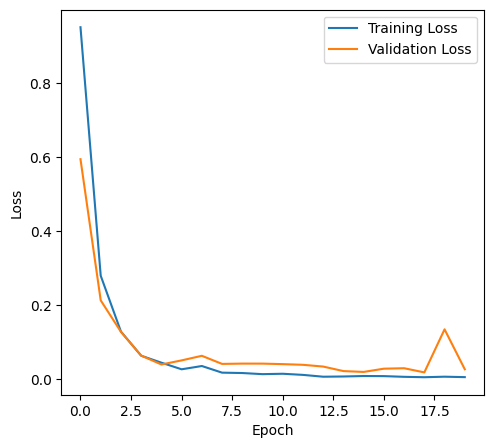

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



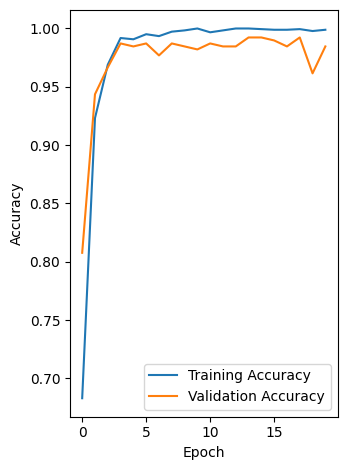

In [12]:
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

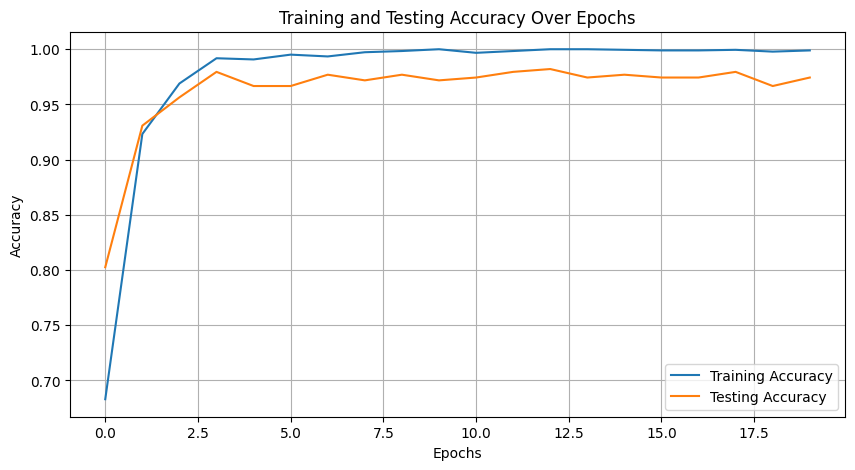

In [13]:
# Plot the training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
!pip install tabulate
from tabulate import tabulate

In [15]:
# Convert actual_labels_test and predicted_labels_test to NumPy arrays for further analysis if needed
actual_labels_test = np.array(actual_labels_test)
predicted_labels_test = np.array(predicted_labels_test)

# Create a table with the data
table_data = []
for i in range(len(actual_labels_test)):
    actual_class = dataset.classes[actual_labels_test[i]]
    predicted_class = dataset.classes[predicted_labels_test[i]]
    table_data.append([i + 1, predicted_class, actual_class])

# Create headers for the table
headers = ["Sample", "Predicted Class", "Actual Class"]

# Print the table
print(tabulate(table_data, headers, tablefmt='grid'))

# Calculate the total number of correct samples for testing
total_correct_test = np.sum(actual_labels_test == predicted_labels_test)

# Print the total number of correct samples
print("Total Correct Samples (Testing):", total_correct_test)


+----------+-----------------------+-----------------------+
|   Sample | Predicted Class       | Actual Class          |
+==========+=======================+=======================+
|        1 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        2 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        3 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        4 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        5 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        6 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        7 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+------------

In [16]:
# ... (previous code remains the same)

# Testing loop
model.eval()
correct_predictions_test = 0
total_samples_test = 0
actual_labels_test = []
predicted_labels_test = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Append actual and predicted labels for testing
        actual_labels_test += labels.cpu().numpy().tolist()
        predicted_labels_test += predicted.cpu().numpy().tolist()

test_accuracy = correct_predictions_test / total_samples_test  # Calculate overall test accuracy

print(f"Total Testing Accuracy: {test_accuracy * 100:.2f}%")


Total Testing Accuracy: 97.44%


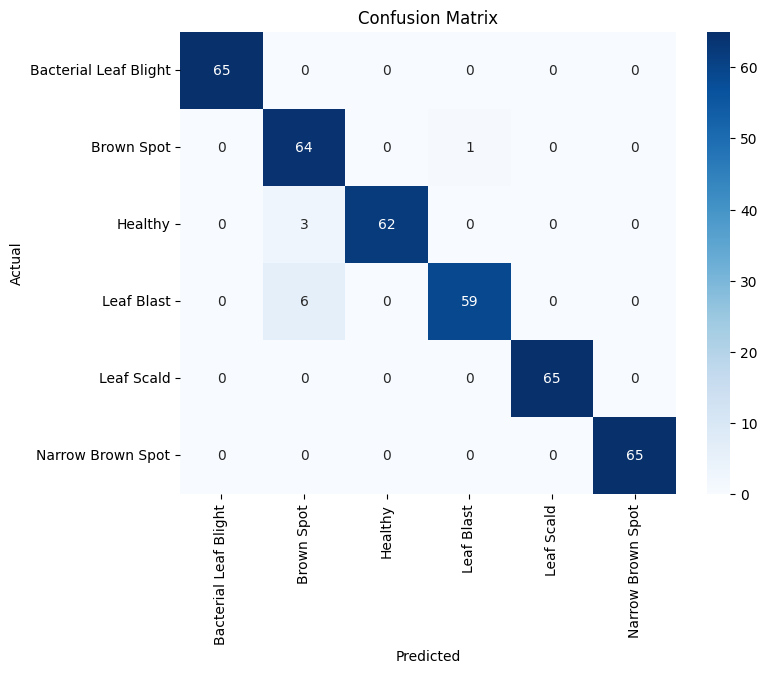

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels_test, predicted_labels_test)

# Get class labels (assuming you have them)
class_labels = [str(i) for i in range(len(confusion))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

# Calculate classification report
class_report = classification_report(actual_labels_test, predicted_labels_test, target_names=dataset.classes, output_dict=True)

# Create a table with the data
# Create a table with the data
table_data = []
for i, class_name in enumerate(dataset.classes):
    correct_samples = conf_matrix[i, i]
    total_samples = np.sum(conf_matrix[i, :])
    accuracy = correct_samples / total_samples * 100
    precision = class_report[class_name]['precision'] * 100
    recall = class_report[class_name]['recall'] * 100
    f1_score = class_report[class_name]['f1-score'] * 100
    table_data.append([class_name,
                       f"{correct_samples:.2f}",
                       f"{total_samples:.2f}",
                       f"{f1_score:.2f}",
                       f"{precision:.2f}",
                       f"{recall:.2f}",
                       f"{accuracy:.2f}"])


# Create headers for the table
headers = ["Class", "Correct Samples", "Total Samples", "F1 Score (%)", "Precision (%)", "Recall (%)", "Accuracy (%)"]

# Print the table
print("Class-wise Metrics:")
print(tabulate(table_data, headers, tablefmt='grid'))

Class-wise Metrics:
+-----------------------+-------------------+-----------------+----------------+-----------------+--------------+----------------+
| Class                 |   Correct Samples |   Total Samples |   F1 Score (%) |   Precision (%) |   Recall (%) |   Accuracy (%) |
+=======================+===================+=================+================+=================+==============+================+
| Bacterial Leaf Blight |                65 |              65 |         100    |          100    |       100    |         100    |
+-----------------------+-------------------+-----------------+----------------+-----------------+--------------+----------------+
| Brown Spot            |                64 |              65 |          92.75 |           87.67 |        98.46 |          98.46 |
+-----------------------+-------------------+-----------------+----------------+-----------------+--------------+----------------+
| Healthy               |                62 |              65 |

Overall Precision: 97.67%
Overall Recall: 97.44%
Overall F1-Score: 97.47%
Overall Accuracy: 97.44%


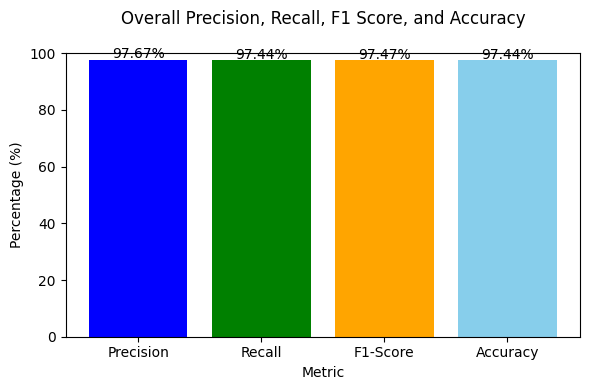

In [19]:
# Calculate overall precision, recall, and F1-score
overall_precision = class_report['weighted avg']['precision'] * 100
overall_recall = class_report['weighted avg']['recall'] * 100
overall_f1_score = class_report['weighted avg']['f1-score'] * 100
overall_accuracy = (total_correct_test / total_samples_test) * 100  # Calculate overall accuracy

# Print overall metrics
print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall Recall: {overall_recall:.2f}%")
print(f"Overall F1-Score: {overall_f1_score:.2f}%")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

# Create labels and values for the metrics
metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
values = [overall_precision, overall_recall, overall_f1_score, overall_accuracy]

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'skyblue'])
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentage values
plt.title('Overall Precision, Recall, F1 Score, and Accuracy\n')
plt.xlabel('Metric')
plt.ylabel('Percentage (%)')

# Display the values on top of the bars
for i, v in enumerate(values):
    plt.text(i, v - 0.5, f'{v:.2f}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


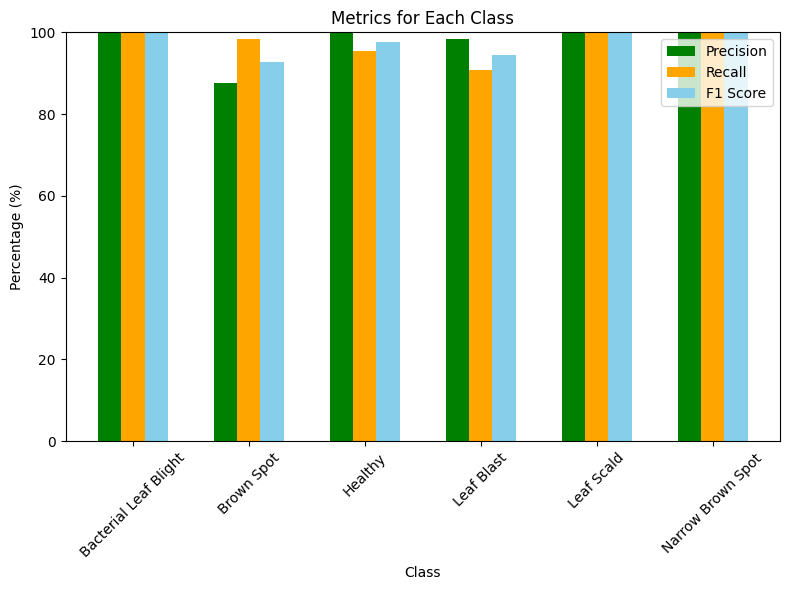

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate class-wise metrics
class_test_accuracy = []
class_precision = []
class_recall = []
class_f1_score = []

for class_idx in range(len(dataset.classes)):
    class_name = dataset.classes[class_idx]
    correct_samples = np.sum(actual_labels_test == class_idx)
    total_samples = np.sum(actual_labels_test == class_idx) + np.sum(actual_labels_test != class_idx)

    # Calculate class-wise accuracy
    class_acc = (correct_samples / total_samples) * 100
    class_test_accuracy.append(class_acc)

    # Retrieve class-wise precision, recall, and F1-score from the classification report
    class_precision.append(class_report[class_name]['precision'] * 100)
    class_recall.append(class_report[class_name]['recall'] * 100)
    class_f1_score.append(class_report[class_name]['f1-score'] * 100)

# Create an array for the x-axis positions of bars
x = np.arange(len(dataset.classes))

# Set the width of the bars
bar_width = 0.2

# Create a figure
plt.figure(figsize=(8, 6))

# Plot test accuracy for each class
#plt.bar(x - bar_width * 2, class_test_accuracy, width=bar_width, label='Test Accuracy', color='blue')

# Plot precision for each class
plt.bar(x - bar_width, class_precision, width=bar_width, label='Precision', color='green')

# Plot recall for each class
plt.bar(x, class_recall, width=bar_width, label='Recall', color='orange')

# Plot F1-score for each class
plt.bar(x + bar_width, class_f1_score, width=bar_width, label='F1 Score', color='skyblue')

# Set x-axis labels and tick positions
plt.xticks(x, dataset.classes, rotation=45)

# Set y-axis limit to 0-100 for percentage values
plt.ylim(0, 100)

# Add legend
plt.legend()

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.title('Metrics for Each Class')

# Show the plot
plt.tight_layout()
plt.show()
